In [10]:
library(tidyverse)
library(readr)
library(ggplot2)
library(dplyr)

In [11]:
players <- read_csv("data/players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [12]:
sessions <- read_csv("data/sessions.csv")

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [13]:
colnames(players)
colnames(sessions)

[1] "experience"   "subscribe"    "hashedEmail"  "played_hours" "name"        
[6] "gender"       "Age"

[1] "hashedEmail"         "start_time"          "end_time"           
[4] "original_start_time" "original_end_time"

In [27]:
# To Clean and Merge Data

# Clean and prepare the sessions data

sessions <- sessions %>%
  rename(
    player = hashedEmail,
    start = start_time,
    end = end_time
  ) %>%
  mutate(
    start = ymd_hms(start),
    end = ymd_hms(end),
    duration = as.numeric(difftime(end, start, units = "mins"))
  ) %>%
  filter(!is.na(duration) & duration > 0)

# Clean the players data 

players <- players %>%
  rename(player = hashedEmail) %>%
  mutate(
    Age = as.integer(Age),
    played_hours = as.numeric(played_hours),
    subscribe = if_else(subscribe == "TRUE", TRUE, FALSE)
  )

# Merge the datasets together using *_join function (ch3)

merged_data <- left_join(sessions, players, by = "player")



In [28]:
# Summarize player activity

player_summary <- merged_data %>%
  group_by(player) %>%
  summarise(
    first_day = min(as_date(start), na.rm = TRUE),
    num_sessions = n(),
    avg_session_duration = mean(duration, na.rm = TRUE),
    total_playtime = sum(duration, na.rm = TRUE) / 60, # in hours
    active_days = n_distinct(as_date(start)),
    first_week_days = n_distinct(as_date(start)[as_date(start) <= first_day + days(7)])
  )


In [29]:
# Identify high data contributors (top 25%) 

threshold <- quantile(player_summary$total_playtime, 0.75, na.rm = TRUE)

player_summary <- player_summary %>%
  mutate(
    high_contributor = total_playtime >= threshold
  )


In [30]:
# Merge the player summaries with player info for EDA 

eda_data <- left_join(player_summary, players, by = "player")


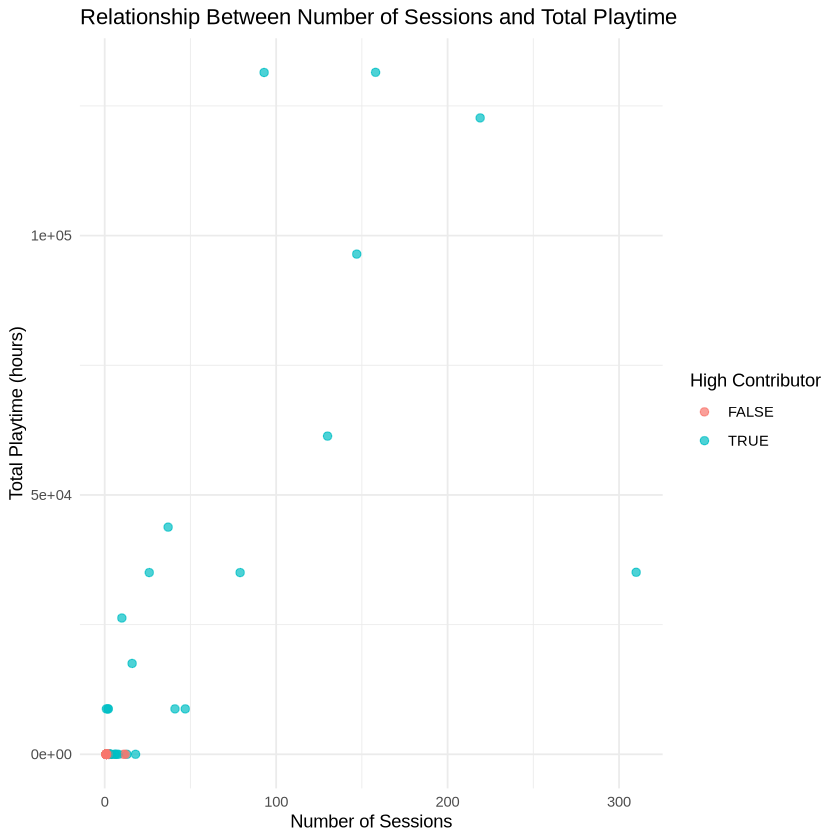

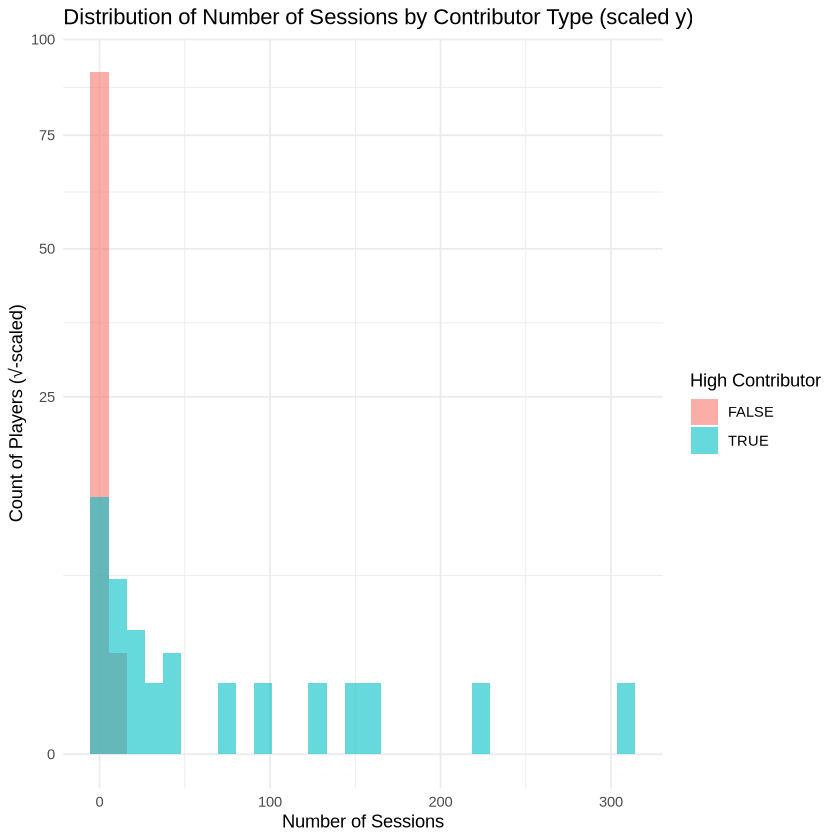

In [31]:
# Relationship between sessions and total playtime ---

ggplot(eda_data, aes(x = num_sessions, y = total_playtime, color = high_contributor)) +
  geom_point(alpha = 0.7, size = 2) +
  labs(
    title = "Relationship Between Number of Sessions and Total Playtime",
    x = "Number of Sessions",
    y = "Total Playtime (hours)",
    color = "High Contributor"
  ) +
  theme_minimal()



# Distribution of session counts by contributor type ---

ggplot(eda_data, aes(x = num_sessions, fill = high_contributor)) +
  geom_histogram(position = "identity", alpha = 0.6, bins = 30) +
  scale_y_sqrt() +
  labs(
    title = "Distribution of Number of Sessions by Contributor Type (scaled y)",
    x = "Number of Sessions",
    y = "Count of Players (√-scaled)",
    fill = "High Contributor"
  ) +
  theme_minimal()


In [32]:
# Summarize key metrics by contributor type ---

eda_summary <- eda_data %>%
  group_by(high_contributor) %>%
  summarise(
    mean_sessions = mean(num_sessions, na.rm = TRUE),
    median_sessions = median(num_sessions, na.rm = TRUE),
    mean_playtime = mean(total_playtime, na.rm = TRUE),
    median_playtime = median(total_playtime, na.rm = TRUE),
    mean_duration = mean(avg_session_duration, na.rm = TRUE),
    median_duration = median(avg_session_duration, na.rm = TRUE),
    n_players = n()
  )

knitr::kable(eda_summary, digits = 2)




|high_contributor | mean_sessions| median_sessions| mean_playtime| median_playtime| mean_duration| median_duration| n_players|
|:----------------|-------------:|---------------:|-------------:|---------------:|-------------:|---------------:|---------:|
|FALSE            |          1.39|             1.0|          0.01|            0.00|          0.35|            0.22|        93|
|TRUE             |         43.78|             7.5|      24373.04|         4380.03|      53745.26|         3396.81|        32|

In [35]:
#Verifying Data is Tidy

eda_data <- eda_data %>%
  select(player, Age, gender, experience, subscribe, played_hours,
         num_sessions, avg_session_duration, total_playtime,
         active_days, first_week_days, high_contributor) %>%
  arrange(desc(total_playtime))
eda_data

player,Age,gender,experience,subscribe,played_hours,num_sessions,avg_session_duration,total_playtime,active_days,first_week_days,high_contributor
<chr>,<int>,<chr>,<chr>,<lgl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<lgl>
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,16,Female,Amateur,TRUE,150.0,158,4.992482e+04,1.314687e+05,70,1,TRUE
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,20,Non-binary,Regular,TRUE,218.1,93,8.480380e+04,1.314459e+05,61,1,TRUE
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,17,Male,Regular,TRUE,223.1,219,3.361273e+04,1.226865e+05,96,1,TRUE
ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83,19,Female,Regular,TRUE,178.2,147,3.935955e+04,9.643089e+04,82,1,TRUE
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17,Male,Amateur,TRUE,53.9,130,2.831182e+04,6.134228e+04,47,1,TRUE
a175d4741dc84e6baf77901f6e8e0a06f54809a34e6b5211159bced346f7fb3e,17,Female,Amateur,TRUE,48.4,37,7.102524e+04,4.379890e+04,23,1,TRUE
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,23,Male,Amateur,TRUE,56.1,310,6.791174e+03,3.508773e+04,100,1,TRUE
24d4892c2c3ce11d3e54c3bf31ee218901cac7a2f564911d67424c8fdf0874fe,22,Male,Amateur,TRUE,32.0,79,2.661194e+04,3.503906e+04,42,1,TRUE
f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,9,Male,Pro,TRUE,30.3,26,8.085905e+04,3.503892e+04,18,1,TRUE


In [36]:
glimpse(eda_data)


Rows: 125
Columns: 12
$ player               <chr> "f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e339…
$ Age                  <int> 16, 20, 17, 19, 17, 17, 23, 22, 9, 27, 49, 14, 17…
$ gender               <chr> "Female", "Non-binary", "Male", "Female", "Male",…
$ experience           <chr> "Amateur", "Regular", "Regular", "Regular", "Amat…
$ subscribe            <lgl> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, T…
$ played_hours         <dbl> 150.0, 218.1, 223.1, 178.2, 53.9, 48.4, 56.1, 32.…
$ num_sessions         <int> 158, 93, 219, 147, 130, 37, 310, 79, 26, 10, 16, …
$ avg_session_duration <dbl> 4.992482e+04, 8.480380e+04, 3.361273e+04, 3.93595…
$ total_playtime       <dbl> 1.314687e+05, 1.314459e+05, 1.226865e+05, 9.64308…
$ active_days          <int> 70, 61, 96, 82, 47, 23, 100, 42, 18, 9, 14, 17, 2…
$ first_week_days      <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ high_contributor     <lgl> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, T…
